In [110]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from datetime import datetime
import scipy.stats as stats
import pickle

In [111]:
orig_sig_cols = list(np.load(os.path.join("../","sig_cols.npy")))

In [112]:
full_data = pd.read_csv(os.path.join("../","data",f"combined_game_data.csv"))
full_data.head()

,G,Date,Age,Tm,game_location,Opp,game_result,GS,MP,FG,...,More-BLKs-Than-STLs,More-AST-Than-TOV,PTS-Cat,2P,2PA,2P%,2P%-Above-50%,More than 3 Fouls,FTR-Above-Avg,Less-Than-3-TOV
0,1,2003-10-29,18,CLE,0,SAC,-14,1.0,42,12.0,...,False,True,below 35,12.0,18.0,0.666667,True,False,False,True
1,2,2003-10-30,18,CLE,0,PHO,-9,1.0,40,8.0,...,False,True,below 35,7.0,12.0,0.583333,True,False,False,False
2,3,2003-11-01,18,CLE,0,POR,-19,1.0,39,3.0,...,False,True,below 20,3.0,11.0,0.272727,False,False,False,True
3,4,2003-11-05,18,CLE,1,DEN,-4,1.0,41,3.0,...,True,True,below 20,3.0,9.0,0.333333,False,False,False,True
4,5,2003-11-07,18,CLE,0,IND,-1,1.0,43,8.0,...,False,False,below 35,7.0,16.0,0.437500,False,False,True,False


<h3>Numerical Feature Engineering</h3>

In [113]:
sig_num_cols = []

In [114]:
corr = full_data.corr()

In [115]:
def correlation_w_threshold(corr,threshold,target_col):
    corr_plus_minus = corr.loc[target_col,:]
    corr_plus_minus_above_thres = corr_plus_minus[(corr_plus_minus>=threshold) | (corr_plus_minus<=-threshold)]
    corr_plus_minus_above_thres.drop(target_col,inplace=True)
    return corr_plus_minus_above_thres.values.reshape(-1,1), corr_plus_minus_above_thres.index

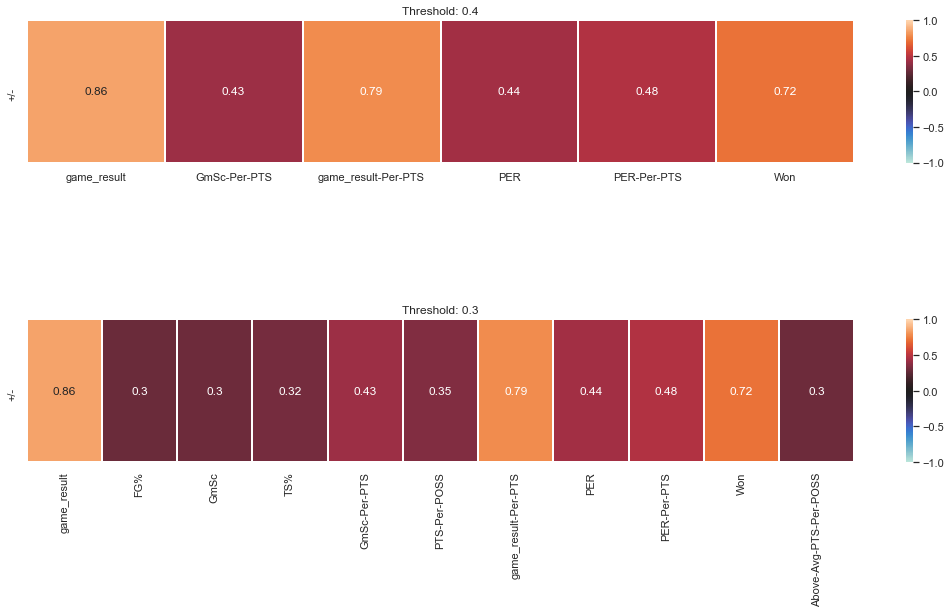

In [116]:
sns.set(font_scale=1)
plt.figure(1,(15,15))
i = 0
epsilon = 0.01
thresholds = [0.4,0.3]
for thres in thresholds:
    i += 1
    ax = plt.subplot(4,1,i)
    corr_above_thres, corr_above_thres_cols = correlation_w_threshold(corr,thres-epsilon,"+/-")
    sns.heatmap(corr_above_thres.T,vmin=-1,vmax=1,center=0,linewidth=1,annot=True,yticklabels=["+/-"],xticklabels=corr_above_thres_cols)
    ax.set_title(f"Threshold: {thres}")
    plt.tight_layout()
plt.show()

In [117]:
def get_ratios(nums_col, dens_col,df=full_data,create=True,new_col=None,target="+/-",print_corr_w_target=True):
    vals = []
    for num, den in zip(df[nums_col], df[dens_col]):
        if den == 0:
            vals.append(float(0))
        else:
            vals.append(num/den)
    vals = np.array(vals)
    corr = np.corrcoef(vals,df[target])[0,1]
    if create and corr >= 0.25:
        df[new_col] = vals
        sig_num_cols.append(new_col)
    if print_corr_w_target:
        print(f"The correlation between {new_col} and {target} is {corr}")

In [118]:
def get_corr(col,target_col="+/-",df=full_data):
    corr = np.corrcoef(df[col],df[target_col])[0,1]
    if corr > 0.25:
        sig_num_cols.append(col)
    return corr

In [119]:
def convert_bin_col_to_bool(df):
    for col in df.columns:
        if len(df[col].unique()) == 2 and 0 in df[col].unique() and 1 in df[col].unique():
            df[col].replace(0,False,inplace=True)
            df[col].replace(1,True,inplace=True)

In [120]:
convert_bin_col_to_bool(full_data)

In [121]:
full_data.columns

Index(['G', 'Date', 'Age', 'Tm', 'game_location', 'Opp', 'game_result', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-',
       'TS%', 'FTR', 'hAST%', 'TOV%', 'AST-TOV', 'DREB%', 'OREB%', 'POSS',
       'Year_Number', 'GmSc-Per-PTS', 'GmSc-Per-FT', 'FTR-Per-FGA',
       'PTS-Per-TOV', 'PTS-Per-POSS', 'game_result-Per-PTS', 'PER',
       'PER-Per-PTS', 'STLS-and-BLKS', 'STL-BLK-Per-PF', 'Won',
       'High-3P%-Shooting', 'High-FG%-Shooting', 'Over-3-BLKs-and-STLs',
       'Played-Above-Avg-Min', 'Above-Avg-FT%', 'Career-Stage',
       'Above-Avg-PTS-Per-POSS', 'More-BLKs-Than-STLs', 'More-AST-Than-TOV',
       'PTS-Cat', '2P', '2PA', '2P%', '2P%-Above-50%', 'More than 3 Fouls',
       'FTR-Above-Avg', 'Less-Than-3-TOV'],
      dtype='object')

In [122]:
full_data["PTS-Per-Min"] = full_data["PTS"] / full_data["MP"]

In [123]:
get_corr("PTS-Per-Min","+/-",full_data)

0.24840805876321145

In [124]:
sig_num_cols.append("PTS-Per-Min")

In [125]:
feature_corr = full_data.drop("+/-",axis=1).corr()

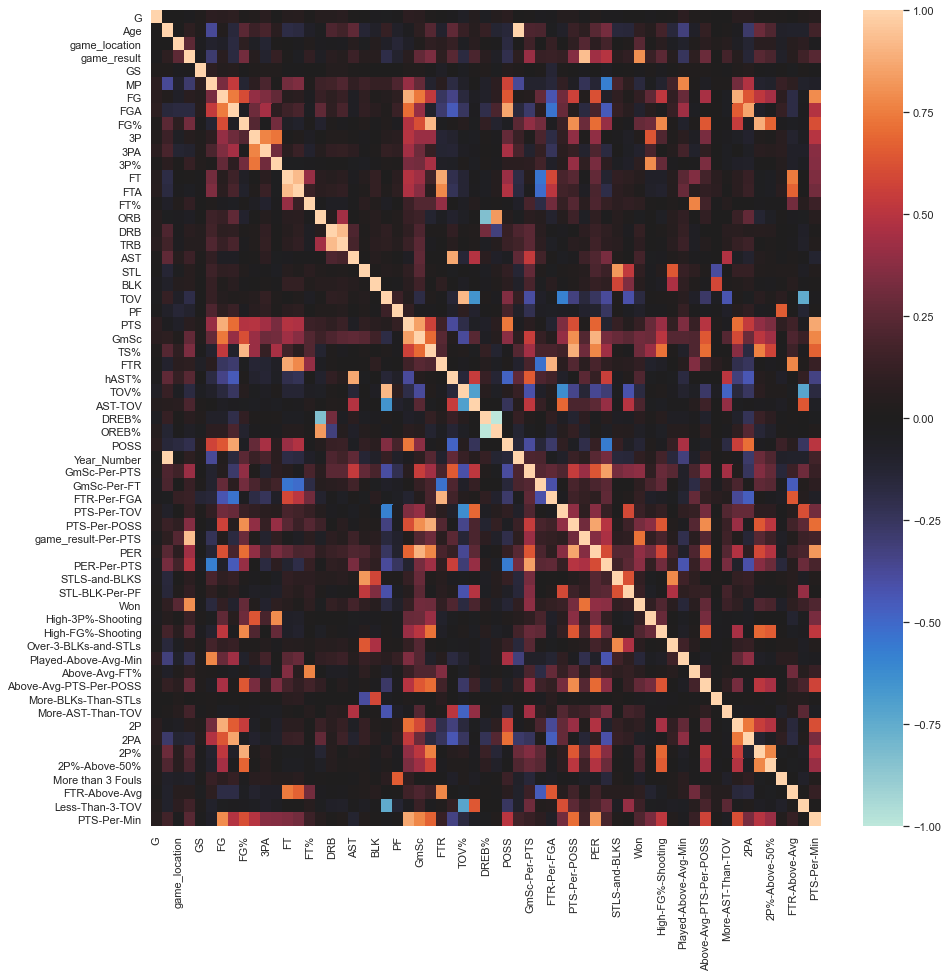

In [126]:
plt.figure(1,(15,15))
sns.heatmap(feature_corr,vmin=-1,center=0,vmax=1)
plt.show()

In [127]:
full_data["%-Avg"] = (full_data["2P%"] + full_data["3P%"]) / 2

In [128]:
get_corr("%-Avg","+/-",full_data)

0.2100104952212212

In [129]:
sig_num_cols.append("%-Avg")

In [130]:
get_ratios("PER", "TOV", new_col="PER-Per-TOV")

The correlation between PER-Per-TOV and +/- is 0.26932799273770247


In [131]:
full_data["POSS"]

0       21.32
1       25.08
2       14.88
3       11.44
4       28.08
        ...  
1255    31.60
1256    23.16
1257    26.20
1258    22.88
1259    21.08
Name: POSS, Length: 1260, dtype: float64

In [132]:
full_data['off_rating'] = full_data['PTS'] * 100 / full_data['POSS'].replace(0, np.inf)

In [133]:
get_corr("off_rating")

0.35485783438267354

<h3>Categorical Feature Engineering</h3>

In [134]:
cat_cols = []

In [135]:
def cat_test(cat_col,target_col="+/-",df=full_data,anova_test=False):
    alpha = 0.05
    unique_cats = df[cat_col].unique()
    data = []
    for cat in unique_cats:
        data_tar = list(df[df[cat_col]==cat][target_col].values)
        data.append(data_tar)
    if not anova_test:
        pvalue = stats.ttest_ind(*data).pvalue
        print(f"{cat_col} is statistically{' not ' if pvalue>alpha else ' '}signficant. The p-value is {pvalue}.")
        if pvalue < alpha:
            cat_cols.append(cat_col)
        return pvalue
    else:
        pvalue = stats.f_oneway(*data).pvalue
        print(f"{cat_col} is statistically{' not ' if pvalue>alpha else ' '}signficant. The p-value is {pvalue}.")
        if pvalue < alpha:
            cat_cols.append(cat_col)
        return pvalue

In [136]:
full_data["off_rating_above_avg"] = full_data["off_rating"] > full_data["off_rating"].mean()

In [137]:
cat_test("off_rating_above_avg")

off_rating_above_avg is statistically signficant. The p-value is 3.04985929317184e-28.


3.04985929317184e-28

In [138]:
full_data["More-Than-Avg-POSS"] = full_data["POSS"] > full_data["POSS"].mean()

In [139]:
cat_test("More-Than-Avg-POSS")

More-Than-Avg-POSS is statistically signficant. The p-value is 5.241296573315022e-07.


5.241296573315022e-07

In [140]:
full_data["GmSc"]

0       24.7
1       14.7
2        5.0
3       11.2
4        9.0
        ... 
1255    31.3
1256    25.8
1257    24.7
1258     9.6
1259    14.3
Name: GmSc, Length: 1260, dtype: float64

In [141]:
full_data["Above-Avg-GmSc"] = full_data["GmSc"] > full_data["GmSc"].mean()

In [142]:
cat_test("Above-Avg-GmSc")

Above-Avg-GmSc is statistically signficant. The p-value is 9.318735759260629e-17.


9.318735759260629e-17

In [143]:
sig_cols = np.array(sig_num_cols + cat_cols + list(orig_sig_cols))

In [144]:
sig_cols

array(['PTS-Per-Min', '%-Avg', 'PER-Per-TOV', 'off_rating',
       'off_rating_above_avg', 'More-Than-Avg-POSS', 'Above-Avg-GmSc',
       'game_result', 'FG%', 'GmSc', 'TS%', 'GmSc-Per-PTS',
       'PTS-Per-POSS', 'game_result-Per-PTS', 'PER', 'game_location',
       'Opp', 'Won', 'High-3P%-Shooting', 'High-FG%-Shooting',
       'Over-3-BLKs-and-STLs', 'Played-Above-Avg-Min', 'Above-Avg-FT%',
       'Career-Stage', 'Above-Avg-PTS-Per-POSS', 'More-BLKs-Than-STLs',
       'More-AST-Than-TOV', 'PTS-Cat', '2P%-Above-50%',
       'More than 3 Fouls'], dtype='<U22')

In [145]:
np.save("sig_cols_ml_iteration_2.npy",sig_cols)

In [147]:
full_data.to_csv("feature_eng_data_iter_2.csv",index=False)